In [2]:
# ------------------ Clustering & ML ------------------
from sklearn.cluster import SpectralBiclustering
from scipy import stats
from scipy.stats import linregress

# ------------------ Core Libraries -------------------
import numpy as np
import pandas as pd
import math
import os
import warnings
import ast
from glob import glob
import itertools

# ------------------ AnnData & Spatial Analysis -------
import scanpy as sc
import squidpy as sq
from anndata import AnnData
import geopandas as gpd

# ------------------ Geometry & Spatial --------------
from shapely.ops import unary_union
from shapely.geometry import Polygon as sPolygon
from matplotlib.patches import Polygon, Patch
from matplotlib.lines import Line2D


# ------------------ Plotting -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap, to_hex
import matplotlib.image as mpimg
import matplotlib as mpl

# ------------------ Image Handling -------------------
from PIL import Image
import cv2
import concurrent.futures
from tqdm.auto import tqdm
import time


# ------------------ Settings -------------------------
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None
%matplotlib inline

# Cell-Cell Interaction Analysis: Summary of Methods and Workflow (using inferred expr. matrix and focus on Secreted Signaling categories)

## Overview
This notebook implements a comprehensive analysis pipeline for studying cell-cell interactions in spatial transcriptomics data. It focuses specifically on secreted signaling interactions between different cell types within a spatial context, with particular emphasis on the specific signaling pathway. The analysis integrates spatial information, gene expression data, and ligand-receptor databases to identify and visualize key signaling patterns.

## Key Components

### 1. Data Preparation and Organization
- **AnnData Processing**: Filters data for a specific field of view (FOV)
- **Cell Geometry Construction**: Creates polygon representations of cells based on spatial coordinates
- **Distance Calculation**: Computes cell-cell distances based on polygon geometries for spatial context

### 2. Ligand-Receptor Interaction Analysis
- **Database Integration**: Processes a curated database of ligand-receptor (L-R) pairs, focusing on secreted signaling molecules
- **Parallel Processing**: Implements an efficient parallel computation framework for calculating L-R interaction scores between all cell pairs
- **Interaction Classification**: Categorizes interactions as autocrine/paracrine and juxtacrine/distant based on cell relationships and distances

### 3. Diffusion Modeling
- **Distance-Based Weighting**: Applies different mathematical models (exponential, Gaussian, power law) to simulate ligand diffusion effects
- **Weighted Scores**: Calculates distance-adjusted interaction scores that better represent the physical reality of secreted signaling

### 4. Visualization Framework
- **Interactive Scatterplots**: Creates scalable visualizations of interaction scores across different cell type combinations
- **Stacked Bar Charts**: Visualizes the proportional contribution of different cell types to signaling interactions
- **Spatial Visualization**: Plots cell-cell interactions directly on the spatial data, showing both source cell ligand expression and target cell interaction scores

### 5. Focused specific Pathway Analysis
- **Pathway Selection**: Filters for specific family ligands and their receptors related to specific pathways
- **Expression Distribution**: Analyzes the distribution of key genes like ligands across cells
- **Cell Type Interactions**: Examines which cell types are primary sources vs. targets in specific signaling

## Analysis Workflow

1. **Data Loading and Preprocessing**:
   - Import libraries and set up the environment
   - Load spatial transcriptomics data and filter for a specific field of view
   - Create cell polygons and calculate inter-cell distances

2. **Expression and Pathway Analysis**:
   - Process ligand-receptor database to identify secreted signaling pairs
   - Focus on Wnt pathway components
   - Analyze expression distributions of relevant genes

3. **Interaction Score Calculation**:
   - Calculate raw interaction scores using parallel processing
   - Apply diffusion models to weight scores by distance
   - Categorize interactions by cell types and interaction patterns

4. **Data Summarization and Visualization**:
   - Create summary statistics for interactions between different cell types
   - Scale data for effective visualization
   - Generate comprehensive visualizations from different analytical perspectives

5. **Result Interpretation**:
   - Identify key patterns of cell-cell communication
   - Quantify relative contributions of different cell types to the signaling network
   - Visualize spatial context of interactions

## Key Analytical Features

- **Efficiency Optimizations**: Parallel processing, selective gene filtering, and optimized data structures
- **Flexible Visualization**: Multiple scaling options, customizable plots, and spatial context preservation
- **Biological Context**: Integration of known ligand-receptor pairs with spatial and expression data
- **Quantitative Approach**: Statistical summarization of interaction patterns between cell populations

This notebook provides a powerful framework for analyzing cell-cell communication in spatial transcriptomics data, with particular focus on understanding how the Wnt signaling pathway operates across different cell types in a tissue microenvironment.

In [3]:
# load data
data_read = '../raw/' # for raw data 
data_save = '../data/' # for processed data or intermediate result
analysis_save = '../analysis/' # for plots
database_read = '../database/' # for online database

adata = sc.read(data_save+'magic/filtered_magic_adata.h5ad')
cell_meta = pd.read_csv(data_save+'filtered_metadata_file.csv', index_col=0)
polygon_file = pd.read_csv(data_save+'filtered_polygons.csv', index_col=0)
coordinates = pd.read_csv(data_save+'filtered_coordinates.csv', index_col=0)
fov_id = [i for i in range(1,23) if i not in [3, 20]]

image = cv2.imread(data_read+"CellComposite/"+"CellComposite_F001.jpg", cv2.IMREAD_COLOR)
xlim_image = image.shape[1]
ylim_image = image.shape[0]

L_R_DB = pd.read_csv(database_read+'Human_CellChat_LR.csv', index_col=0)
L_R_DB_list= L_R_DB['interaction_name_2'].str.split(' - ').tolist()
def sort_ligand_receptor(lr):
    if '+' in lr:
        return lr.strip('()').split('+')
    else:
        return [lr]

L_R_DB_list = [(sort_ligand_receptor(lr[0]), sort_ligand_receptor(lr[1])) for lr in L_R_DB_list]

In [4]:
# focus on one fov
## prepare count, adata, polygon based on fov chosen
fov_chosen = 16
adata_sub = adata[adata.obs['fov'] == fov_chosen]
counts_sub = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names, index=adata_sub.obs_names)
counts_sub['cell'] = counts_sub.index.tolist()

polygon_sub_file = polygon_file[polygon_file['fov'] == fov_chosen]
polygon_set = []
cell_id = []
for cell, group in polygon_sub_file.groupby('cell'):
    polygon_tmp = sPolygon([ (i[0],i[1]) for i in group[['x_local_px', 'y_local_px']].values])
    polygon_set.append(polygon_tmp)
    cell_id.append(cell)
gdf = gpd.GeoDataFrame(geometry=polygon_set)
gdf['cell'] = cell_id
gdf = gdf.merge(adata_sub.obs[['cell','big_cell_type']],on='cell')
gdf

,geometry,cell,big_cell_type
0,"POLYGON ((3400 3644, 3405 3643, 3413 3641, 341...",16_10,IM
1,"POLYGON ((1272 3202, 1277 3201, 1280 3200, 129...",16_1000,IM
2,"POLYGON ((1528 3202, 1533 3196, 1538 3189, 153...",16_1001,IM
3,"POLYGON ((3876 3189, 3880 3185, 3880 3184, 384...",16_1002,IM
4,"POLYGON ((888 3196, 889 3195, 893 3187, 895 31...",16_1004,FB
...,...,...,...
1695,"POLYGON ((910 3209, 964 3190, 966 3186, 967 31...",16_994,IM
1696,"POLYGON ((2890 3212, 2895 3211, 2898 3210, 291...",16_996,IM
1697,"POLYGON ((4427 3202, 4453 3194, 4465 3190, 448...",16_997,IM
1698,"POLYGON ((1472 3208, 1477 3207, 1480 3206, 148...",16_998,FB


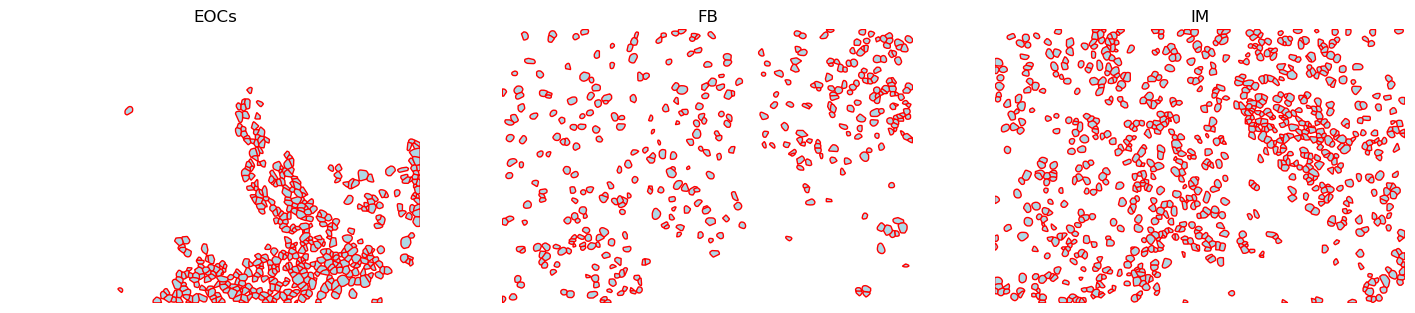

In [5]:
## group cells (optional if we do not want to use leiden clustering) based on spatial locations
fig, axs = plt.subplots(1,3,figsize=(18,6))
axs = axs.flatten()



### EOCs
ax = axs[0]
gdf_EOC = gdf[gdf['big_cell_type'] == 'EOC']
gdf_EOC.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("EOCs")

### FB
ax = axs[1]
gdf_FB = gdf[gdf['big_cell_type'] == 'FB']
gdf_FB.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("FB")

### IM
ax = axs[2]
gdf_IM = gdf[gdf['big_cell_type'] == 'IM']
gdf_IM.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("IM")


plt.show()


In [6]:
# analyze data based on Secreted Signaling (SS) L-R pairs for chosen fov
def calculate_polygon_distances(gdf, name_column=None):
    # Create an empty matrix to store distances
    n = len(gdf)
    distance_matrix = np.zeros((n, n))
    
    # Get the polygon geometries
    geometries = gdf.geometry.values
    
    # Determine what to use for row/column labels
    if name_column and name_column in gdf.columns:
        # Use the specified column for cell names
        cell_names = gdf[name_column].tolist()
    else:
        # Use the index if no name column is specified
        cell_names = gdf.cell.tolist()
    
    # Calculate distances between each pair of polygons
    for i in range(n):
        for j in range(i+1, n):  # Only calculate upper triangle to avoid redundancy
            # Calculate the minimum distance between boundaries
            dist = geometries[i].distance(geometries[j])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist  # Matrix is symmetric
    
    # Convert to DataFrame with cell names as labels
    distance_df = pd.DataFrame(distance_matrix, index=cell_names, columns=cell_names)
    
    return distance_df

# Calculate distances
distances = calculate_polygon_distances(gdf)

In [7]:
# for Secreted Signaling category
L_R_DB = pd.read_csv(database_read+'Human_CellChat_LR.csv', index_col=0)
L_R_DB_list = L_R_DB[L_R_DB['annotation'] == 'Secreted Signaling']
L_R_DB_list= L_R_DB_list['interaction_name_2'].str.split(' - ').tolist()
def sort_ligand_receptor(lr):
    if '+' in lr:
        return lr.strip('()').split('+')
    else:
        return [lr]

L_R_DB_list = [(sort_ligand_receptor(lr[0]), sort_ligand_receptor(lr[1])) for lr in L_R_DB_list]

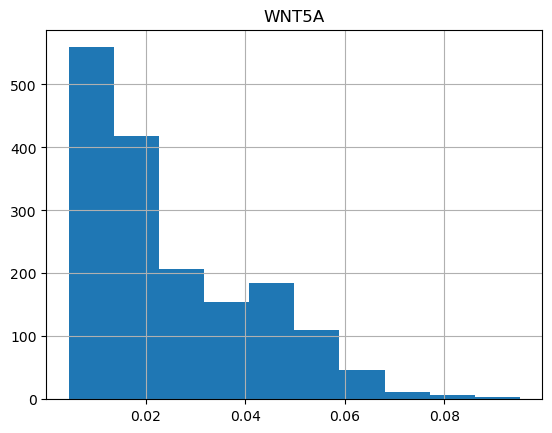

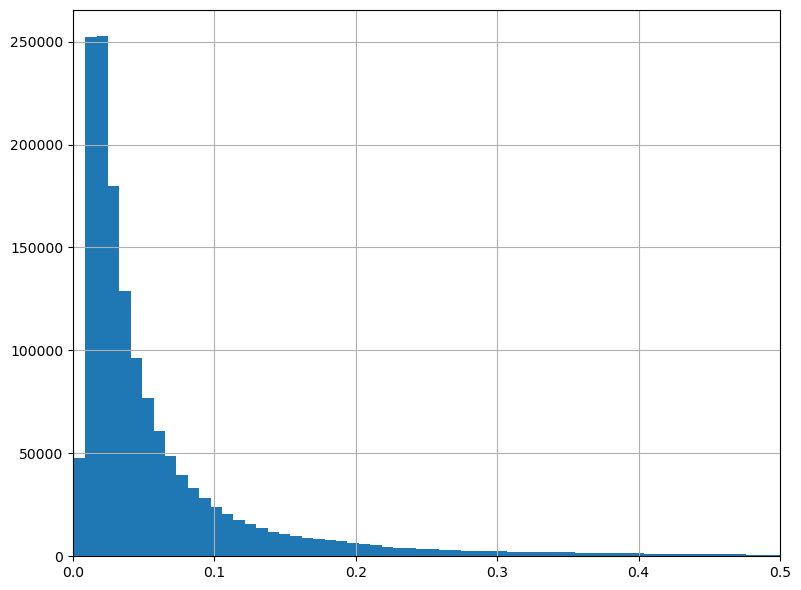

In [16]:
## checking the data distribution for all and target genes
counts_sub.drop(columns='cell').hist('WNT5A')
plt.show()

pd.concat([counts_sub.drop(columns='cell')[col] for col in counts_sub.drop(columns='cell').select_dtypes(include='number')], ignore_index=True).hist(bins=400,figsize=(8, 6))
plt.tight_layout()
plt.xlim((0,0.5))
plt.show()


In [33]:
# to increase the efficiency and to decrease the computational load
## select specific L-R pairs based on previous analysis using un-inferred data
## curate the expr. matrix to keep only L-R genes
L_R_DB = pd.read_csv(database_read+'Human_CellChat_LR.csv', index_col=0)
L_R_DB = L_R_DB[L_R_DB['ligand.family'] == 'Wnt']
L_R_DB_list= L_R_DB['interaction_name_2'].str.split(' - ').tolist()
def sort_ligand_receptor(lr):
    if '+' in lr:
        return lr.strip('()').split('+')
    else:
        return [lr]

L_R_DB_list = [(sort_ligand_receptor(lr[0]), sort_ligand_receptor(lr[1])) for lr in L_R_DB_list]
expr_mat = counts_sub.drop(columns='cell')
L_R_DB_list = [i for i in L_R_DB_list if any(gene in expr_mat.columns for gene in i[0]) and any(gene in expr_mat.columns for gene in i[1])]
tmp = [i[0]+i[1] for i in L_R_DB_list]
tmp = [i for sublist in tmp for i in sublist]
tmp = list(set(tmp))
expr_mat = expr_mat[[i for i in tmp if i in expr_mat.columns]]

In [45]:
def calculate_lr_products_for_all_cells_parallel(distance_df, expression_df, lr_pairs_list, add_pseudocount=True, 
                                               n_workers=None, chunk_size=None, method='thread',cut_off_value=0):
    """
    Calculate ligand-receptor products for ALL cell pairs using parallel processing.
    
    Parameters:
    -----------
    distance_df : pandas DataFrame
        Distance matrix with cell IDs as index and columns
    expression_df : pandas DataFrame
        Expression matrix with cell IDs as index and gene names as columns
    lr_pairs_list : list
        List of ligand-receptor pairs in format [(ligand_list, receptor_list), ...]
    add_pseudocount : bool, default=True
        Whether to add 1 to all expression values before calculating products
    n_workers : int, default=None
        Number of parallel workers (defaults to number of CPU cores)
    chunk_size : int, default=None
        Size of ligand-receptor pair chunks to process in parallel
        If None, will use a heuristic based on the number of pairs
    method : str, default='thread'
        Parallelization method: 'thread' or 'process'
        'thread' is faster for I/O-bound operations
        'process' is better for CPU-bound calculations but has more overhead
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with ligand-receptor products for all cell pairs
    """
    print(f"Starting parallel L-R product calculation...")
    start_time = time.time()
    
    # Create all possible cell pairs from the expression data
    all_cells = expression_df.index.tolist()
    n_cells = len(all_cells)
    print(f"Processing {n_cells} cells ({n_cells**2} potential cell pairs)")
    
    # Apply pseudocount if requested
    if add_pseudocount:
        expr_df = expression_df.copy() + 1
    else:
        expr_df = expression_df.copy()
    
    # Determine chunk size for parallelization
    n_pairs = len(lr_pairs_list)
    if chunk_size is None:
        # Heuristic: aim for ~100 chunks or 10 pairs per chunk, whichever gives more chunks
        chunk_size = max(1, min(10, n_pairs // 100))
    
    # Split LR pairs into chunks
    chunks = [lr_pairs_list[i:i+chunk_size] for i in range(0, n_pairs, chunk_size)]
    print(f"Splitting {n_pairs} L-R pairs into {len(chunks)} chunks of size ~{chunk_size}")
    
    # Define the worker function that processes one chunk of L-R pairs
    def process_lr_chunk(lr_chunk):
        chunk_results = []
        
        for pair in lr_chunk:
            # Extract ligand and receptor information
            ligands = pair[0]
            
            # Skip if any ligand is missing from expression data
            if not all(lig in expr_df.columns for lig in ligands):
                continue
            
            # Format ligand name
            ligand_name = '+'.join(ligands) if len(ligands) > 1 else ligands[0]
            
            # For each receptor or receptor complex in this pair
            for i in range(1, len(pair)):
                receptors = pair[i]
                
                # Skip if any receptor is missing from expression data
                if not all(rec in expr_df.columns for rec in receptors):
                    continue
                
                # Format receptor name
                receptor_name = '+'.join(receptors) if len(receptors) > 1 else receptors[0]
                
                # Process all cell pairs for this ligand-receptor combination
                for source_idx, source_cell in enumerate(all_cells):
                    # Pre-calculate ligand expression for this source cell
                    if len(ligands) == 1:
                        ligand_expr = expr_df.loc[source_cell, ligands[0]]
                        orig_ligand_expr = expression_df.loc[source_cell, ligands[0]]
                    else:
                        ligand_exprs = [expr_df.loc[source_cell, lig] for lig in ligands]
                        ligand_expr = np.prod(ligand_exprs)
                        orig_ligand_exprs = [expression_df.loc[source_cell, lig] for lig in ligands]
                        orig_ligand_expr = np.prod(orig_ligand_exprs)
                    
                    # Skip source cells with zero ligand expression to save time
                    if orig_ligand_expr <= cut_off_value:
                        continue
                    
                    for target_idx, target_cell in enumerate(all_cells):
                        # Get distance if available
                        if distance_df is not None:
                            try:
                                distance = distance_df.loc[source_cell, target_cell]
                            except:
                                distance = None
                        else:
                            distance = None
                        
                        # Calculate receptor expression for this target cell
                        if len(receptors) == 1:
                            receptor_expr = expr_df.loc[target_cell, receptors[0]]
                            orig_receptor_expr = expression_df.loc[target_cell, receptors[0]]
                        else:
                            receptor_exprs = [expr_df.loc[target_cell, rec] for rec in receptors]
                            receptor_expr = np.prod(receptor_exprs)
                            orig_receptor_exprs = [expression_df.loc[target_cell, rec] for rec in receptors]
                            orig_receptor_expr = np.prod(orig_receptor_exprs)
                        
                        # Skip target cells with zero receptor expression to save time
                        if orig_receptor_expr <= cut_off_value:
                            continue
                        
                        
                        # Calculate product
                        product = ligand_expr * receptor_expr
                        
                        # Determine interaction type
                        interaction_type = 'autocrine' if source_cell == target_cell else 'paracrine'
                        
                        # Add distance-based classification if distance is available
                        if distance is not None:
                            if distance == 0:
                                interaction_subtype = 'juxtacrine' if source_cell != target_cell else 'autocrine'
                            else:
                                interaction_subtype = 'distant'
                        else:
                            interaction_subtype = 'unknown'
                        
                        # Add to results
                        result = {
                            'source_cell': source_cell,
                            'target_cell': target_cell,
                            'ligand': ligand_name,
                            'receptor': receptor_name,
                            'original_ligand_expression': orig_ligand_expr,
                            'original_receptor_expression': orig_receptor_expr,
                            'ligand_expression_with_pseudocount': ligand_expr,
                            'receptor_expression_with_pseudocount': receptor_expr,
                            'product': product,
                            'interaction_type': interaction_type,
                            'interaction_subtype': interaction_subtype
                        }
                        
                        # Add distance if available
                        if distance is not None:
                            result['distance'] = distance
                        
                        chunk_results.append(result)
                        
        return chunk_results
    
    # Use the appropriate parallel executor based on the method
    executor_class = concurrent.futures.ThreadPoolExecutor if method == 'thread' else concurrent.futures.ProcessPoolExecutor
    
    # Process chunks in parallel
    all_results = []
    with executor_class(max_workers=n_workers) as executor:
        # Map the chunks to the executor and show progress with tqdm
        futures = list(tqdm(executor.map(process_lr_chunk, chunks), 
                          total=len(chunks),
                          desc="Processing L-R chunks"))
        
        # Combine results from all workers
        for future_result in futures:
            all_results.extend(future_result)
    
    # Create DataFrame from results
    if all_results:
        result_df = pd.DataFrame(all_results)
        
        # Sort by product value (descending)
        result_df = result_df.sort_values('product', ascending=False)
        
        elapsed_time = time.time() - start_time
        print(f"Parallel calculation completed in {elapsed_time:.2f} seconds")
        print(f"Found {len(result_df)} L-R interactions")
        
        return result_df
    else:
        print("No ligand-receptor interactions found.")
        return pd.DataFrame()

# Run the parallel calculation
result_df = calculate_lr_products_for_all_cells_parallel(
    distance_df=distances,
    expression_df=expr_mat,
    lr_pairs_list=L_R_DB_list,
    add_pseudocount=True,
    n_workers=10,  # Adjust based on your CPU
    method='thread')  # Use 'process' for CPU-bound calculations

Starting parallel L-R product calculation...
Processing 1700 cells (2890000 potential cell pairs)
Splitting 105 L-R pairs into 105 chunks of size ~1


Processing L-R chunks: 100%|██████████| 105/105 [18:10<00:00, 10.39s/it]


Parallel calculation completed in 1266.21 seconds
Found 60690000 L-R interactions


In [49]:
df = result_df.merge(adata_sub.obs[['cell','big_cell_type']], left_on='source_cell', right_on='cell', how='left')
df = df.rename(columns={
    'big_cell_type': 'source_cell_label'
})
df = df.merge(adata_sub.obs[['cell','big_cell_type']], left_on='target_cell', right_on='cell', how='left')
df = df.rename(columns={
    'big_cell_type': 'target_cell_label'
})
df['group'] = df['source_cell_label'].astype(str) + "_" + df['target_cell_label'].astype(str)
df['L_R'] = df['ligand'] + "_" + df['receptor']
df

,source_cell,target_cell,ligand,receptor,original_ligand_expression,original_receptor_expression,ligand_expression_with_pseudocount,receptor_expression_with_pseudocount,product,interaction_type,interaction_subtype,distance,cell_x,source_cell_label,cell_y,target_cell_label,group,L_R
0,16_442,16_2484,WNT5B,FZD4,0.157980,0.283701,1.157980,1.283701,1.486500,paracrine,distant,4834.346388,16_442,EOC,16_2484,IM,EOC_IM,WNT5B_FZD4
1,16_2350,16_2484,WNT5B,FZD4,0.153023,0.283701,1.153023,1.283701,1.480136,paracrine,distant,4227.630660,16_2350,EOC,16_2484,IM,EOC_IM,WNT5B_FZD4
2,16_1985,16_2484,WNT5B,FZD4,0.150336,0.283701,1.150336,1.283701,1.476687,paracrine,distant,4456.515455,16_1985,EOC,16_2484,IM,EOC_IM,WNT5B_FZD4
3,16_2334,16_2484,WNT5B,FZD4,0.150042,0.283701,1.150042,1.283701,1.476310,paracrine,distant,3937.659457,16_2334,EOC,16_2484,IM,EOC_IM,WNT5B_FZD4
4,16_442,16_667,WNT5B,FZD4,0.157980,0.274720,1.157980,1.274720,1.476101,paracrine,distant,4919.014739,16_442,EOC,16_667,IM,EOC_IM,WNT5B_FZD4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60689995,16_2134,16_2028,WNT11,FZD7,0.002016,0.003029,1.002016,1.003029,1.005051,paracrine,distant,161.505418,16_2134,IM,16_2028,IM,IM_IM,WNT11_FZD7
60689996,16_2068,16_32,WNT11,FZD7,0.002083,0.002725,1.002083,1.002725,1.004814,paracrine,distant,3286.614824,16_2068,IM,16_32,IM,IM_IM,WNT11_FZD7
60689997,16_2134,16_32,WNT11,FZD7,0.002016,0.002725,1.002016,1.002725,1.004747,paracrine,distant,2625.192183,16_2134,IM,16_32,IM,IM_IM,WNT11_FZD7
60689998,16_2068,16_1520,WNT11,FZD7,0.002083,0.002130,1.002083,1.002130,1.004218,paracrine,distant,2279.559607,16_2068,IM,16_1520,IM,IM_IM,WNT11_FZD7


<Figure size 600x3000 with 0 Axes>

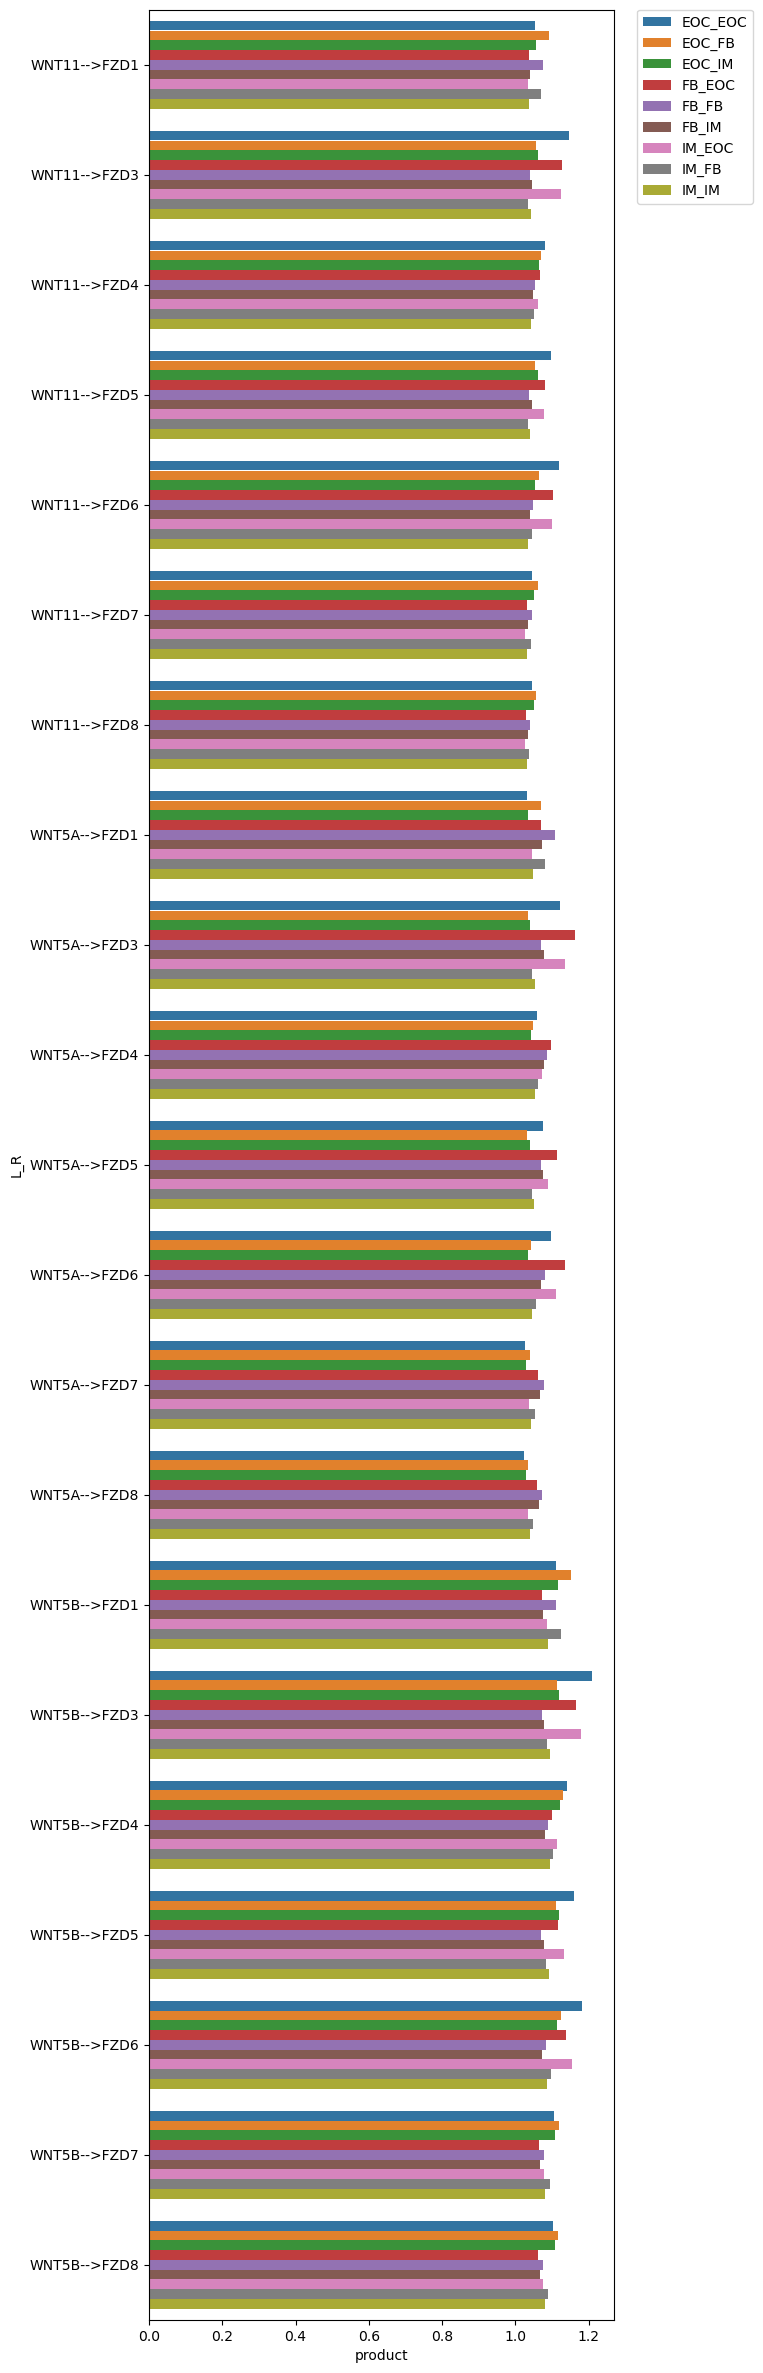

In [141]:
df_summary = df[['ligand', 'receptor', 'group', 'product']].groupby(['ligand', 'receptor', 'group']).mean()
df_summary = df_summary.reset_index()
df_summary['L_R'] = df_summary['ligand'].astype(str) + '-->' + df_summary['receptor'].astype(str)

plt.figure(figsize=(6,30))
sns.barplot(df_summary, x='product', y='L_R', hue='group')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

In [ ]:
# take diffusion model into consideration (compare activities of L-R pairs from different cell-cell interactions within respective L-R pairs)
# factors considered: distance
# factors not considered: temperature, ECM factors, diffusion rate for different ligands

def apply_distance_effect_precomputed(lr_distance_scores, model='exp', params=None, pixels_per_um=None):
    """
    Apply distance-based weighting to ligand-receptor interaction scores
    with pre-computed distances.
    
    Parameters:
    -----------
    lr_distance_scores : pandas DataFrame
        DataFrame with columns: sender_cell, receiver_cell, ligand, receptor, score, distance
        The distance column should contain the pre-computed distances between cells
    model : str
        Diffusion model to use: 'exp' (exponential), 'gaussian', or 'power'
    params : dict
        Parameters for the diffusion model
    pixels_per_um : num
        Parameters for CosMx spec
        
    Returns:
    --------
    weighted_scores : pandas DataFrame
        Original lr_scores with added weight and weighted_score columns
    """
    pixel_factor = 1 if pixels_per_um is None else pixels_per_um
    if params is None:
        # Default parameters
        params = {
            'exp': {'lambda': 100 * pixel_factor},  # μm
            'gaussian': {'sigma': 50 * pixel_factor},  # μm
            'power': {'n': 2, 'r0': 10 * pixel_factor}  # μm
        }
    
    # Create a copy of the input DataFrame
    weighted_scores = lr_distance_scores.copy()
    
    # Apply weighting based on the selected model
    if model == 'exp':
        lambda_param = params['exp']['lambda']
        weighted_scores['weight'] = np.exp(-weighted_scores['distance'] / lambda_param)
    
    elif model == 'gaussian':
        sigma = params['gaussian']['sigma']
        weighted_scores['weight'] = np.exp(-(weighted_scores['distance']**2) / (2 * sigma**2))
    
    elif model == 'power':
        n = params['power']['n']
        r0 = params['power']['r0']
        # Add small epsilon to avoid division by zero
        weighted_scores['weight'] = (r0 / (weighted_scores['distance'] + 1e-10))**n
        # Cap the maximum weight to 1
        weighted_scores['weight'] = np.minimum(weighted_scores['weight'], 1.0)
    
    # Calculate weighted scores
    weighted_scores['weighted_score'] = weighted_scores['score'] * weighted_scores['weight']
    
    return weighted_scores


def visualize_distance_effect(weighted_scores, model_type):
    """
    Visualize how distance affects the interaction scores.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(weighted_scores['distance'], weighted_scores['weight'], alpha=0.5)
    plt.scatter(weighted_scores['distance'], weighted_scores['weighted_score'], 
                alpha=0.5, color='red')
    plt.xlabel('Distance (pixels)')
    plt.ylabel('Value')
    plt.title(f'Effect of Distance ({model_type} model)')
    plt.legend(['Weight', 'Weighted Score'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_ligand_specific_effects(weighted_scores):
    """
    Visualize how distance affects different ligands.
    """
    # Create a categorical color map based on ligand
    ligands = weighted_scores['ligand'].unique()
    
    plt.figure(figsize=(12, 8))
    
    for ligand in ligands:
        subset = weighted_scores[weighted_scores['ligand'] == ligand]
        plt.scatter(subset['distance'], subset['weight'], label=ligand, alpha=0.7)
    
    plt.xlabel('Distance (pixels)')
    plt.ylabel('Weight')
    plt.title('Distance Effect on Different Ligands')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare diffusion coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='ligand', y='diffusion_coef', 
                data=weighted_scores.drop_duplicates('ligand').sort_values('diffusion_coef', ascending=False))
    plt.xlabel('Ligand')
    plt.ylabel('Diffusion Coefficient (pixels²/s)')
    plt.title('Diffusion Coefficients for Different Ligands')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# df['score'] = df['product']
# df_weighted = apply_distance_effect_precomputed(df, model='exp')
# visualize_distance_effect(df_weighted, model_type='exp') # please downsample and then run it
# visualize_ligand_specific_effects(df_weighted) # same as above

In [130]:
def prepare_summary_data(df_weighted, filter_threshold=None):
    """
    Prepare summary data for cell-cell interaction visualization.
    
    Parameters:
    -----------
    df_weighted : pandas DataFrame
        DataFrame containing interaction data with columns 'ligand', 'receptor', 'group', 'weighted_score'
    filter_threshold : float, optional
        If provided, only include interactions with weighted_score >= threshold
        
    Returns:
    --------
    pandas DataFrame
        Processed summary DataFrame ready for visualization
    """
    # Prepare summary data
    df_summary = df_weighted[['ligand', 'receptor', 'group', 'weighted_score']].copy()
    if 'distance' in df_weighted.columns:
        df_summary['distance'] = df_weighted['distance']
    
    # Group by ligand-receptor-group and calculate mean
    df_summary = df_summary.groupby(['ligand', 'receptor', 'group']).mean().reset_index()
    
    # Create L_R column
    df_summary['L_R'] = df_summary['ligand'].astype(str) + '-->' + df_summary['receptor'].astype(str)
    
    # Apply filter if threshold is provided
    if filter_threshold is not None:
        df_summary = df_summary[df_summary['weighted_score'] >= filter_threshold]
    
    return df_summary

def scale_summary_data(df_summary, scaling_method='row', sort_by=None):
    """
    Apply scaling to summary data for cell-cell interaction visualization.
    
    Parameters:
    -----------
    df_summary : pandas DataFrame
        DataFrame containing interaction data with columns 'group', 'weighted_score', 'L_R'
    scaling_method : str, optional
        Scaling method to use: 'row' (per L-R pair), 'global', or 'both' (returns both)
    sort_by : str or list, optional
        How to sort the L-R pairs: 'alphabetical', 'weighted_score', 'group_count', or a list of L-R pairs
        
    Returns:
    --------
    dict
        Dictionary of DataFrames with scaled values for each scaling method
    """
    # Sort L-R pairs if requested
    if sort_by == 'alphabetical':
        lr_order = sorted(df_summary['L_R'].unique())
    elif sort_by == 'weighted_score':
        lr_order = df_summary.groupby('L_R')['weighted_score'].sum().sort_values(ascending=False).index.tolist()
    elif sort_by == 'group_count':
        lr_order = df_summary.groupby('L_R').size().sort_values(ascending=False).index.tolist()
    elif isinstance(sort_by, list):
        # User provided custom order
        lr_order = sort_by
    else:
        # No sorting, use order as appears in data
        lr_order = df_summary['L_R'].unique()
    
    # Define a function for row-wise min-max scaling
    def min_max_scale(group):
        min_val = group['weighted_score'].min()
        max_val = group['weighted_score'].max()
        # Avoid division by zero if min and max are the same
        denominator = max_val - min_val
        if denominator == 0:
            group['weighted_score_scaled'] = 1.0  # All values are equal, so set to 1
        else:
            group['weighted_score_scaled'] = (group['weighted_score'] - min_val) / denominator
        return group
    
    # Create scaled DataFrames based on the requested method
    scaled_dfs = {'lr_order': lr_order}
    
    if scaling_method in ['row', 'both']:
        # Row-wise scaling (per L-R pair)
        row_scaled_df = df_summary[['group', 'weighted_score', 'L_R']].groupby('L_R', group_keys=False).apply(min_max_scale)
        scaled_dfs['row'] = row_scaled_df
    
    if scaling_method in ['global', 'both']:
        # Global scaling (across all L-R pairs)
        global_scaled_df = df_summary[['group', 'weighted_score', 'L_R']].copy()
        min_val = global_scaled_df['weighted_score'].min()
        max_val = global_scaled_df['weighted_score'].max()
        
        # Avoid division by zero
        if max_val > min_val:
            global_scaled_df['weighted_score_scaled'] = (global_scaled_df['weighted_score'] - min_val) / (max_val - min_val)
        else:
            global_scaled_df['weighted_score_scaled'] = 1.0
        
        scaled_dfs['global'] = global_scaled_df
    
    return scaled_dfs

def create_interaction_scatterplot(scaled_df, scaling_type='row', lr_order=None, save_dir=None, 
                                  figsize=(6, 35), cmap='viridis', 
                                  min_dot_size=20, max_dot_size=200,
                                  show_values=False, value_fontsize=6):
    """
    Create a scatterplot visualization of cell-cell interactions from scaled data.
    
    Parameters:
    -----------
    scaled_df : pandas DataFrame
        DataFrame containing scaled interaction data with columns 'group', 'weighted_score', 'L_R', 'weighted_score_scaled'
    scaling_type : str
        Type of scaling used ('row' or 'global') - used for the plot title
    lr_order : list, optional
        Custom order for L-R pairs on the y-axis
    save_dir : str, optional
        Directory to save the output plots. If None, plots are only displayed.
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (6, 35).
    cmap : str, optional
        Colormap to use for the heatmap. Default is 'viridis'.
    min_dot_size : int, optional
        Minimum dot size for the scatter plot
    max_dot_size : int, optional
        Maximum dot size for the scatter plot
    show_values : bool, optional
        Whether to show the raw weighted score values as text annotations
    value_fontsize : int, optional
        Font size for value annotations if show_values is True
        
    Returns:
    --------
    tuple
        (fig, ax) matplotlib figure and axis objects
    """
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a copy of the DataFrame to avoid modifying the original
    plot_df = scaled_df.copy()
    
    # Create categorical order for the y-axis if lr_order is provided
    if lr_order is not None:
        plot_df['L_R'] = pd.Categorical(plot_df['L_R'], categories=lr_order, ordered=True)
    
    # Create the scatter plot
    scatter = sns.scatterplot(data=plot_df,
                x='group',
                y='L_R',
                hue='weighted_score_scaled',
                size='weighted_score_scaled',
                sizes=(min_dot_size, max_dot_size),
                palette=cmap,
                ax=ax)
    
    # Add absolute weighted score as text annotation if requested
    if show_values:
        for idx, row in plot_df.iterrows():
            x_pos = plot_df.columns.get_loc('group')
            y_pos = plot_df.columns.get_loc('L_R')
            ax.text(row[x_pos], row[y_pos], f"{row['weighted_score']:.2f}", 
                   fontsize=value_fontsize, ha='center', va='center')
    
    plt.xticks(rotation='vertical')
    plt.title(f'SS in paracrine/autocrine of cell types ({scaling_type} scaling)')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Scaled Score')
    plt.tight_layout()
    
    # Save the plot if requested
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/CCI_SS_{scaling_type}_scaled.png", dpi=300, bbox_inches='tight')
    
    return fig, ax

def visualize_all_interactions(df_weighted, scaling_methods=['row', 'global'], filter_threshold=None, 
                             sort_by=None, save_dir=None, **kwargs):
    """
    Comprehensive function to prepare data, scale it, and create visualizations in one call.
    
    Parameters:
    -----------
    df_weighted : pandas DataFrame
        DataFrame containing interaction data
    scaling_methods : list
        List of scaling methods to use ('row', 'global', or both)
    filter_threshold : float, optional
        Threshold for filtering weak interactions
    sort_by : str or list, optional
        How to sort the L-R pairs
    save_dir : str, optional
        Directory to save the output plots
    **kwargs : dict
        Additional arguments to pass to create_interaction_scatterplot
        
    Returns:
    --------
    dict
        Dictionary of scaled DataFrames and visualizations
    """
    # Prepare the data
    df_summary = prepare_summary_data(df_weighted, filter_threshold)
    
    # Scale the data
    scaled_data = scale_summary_data(df_summary, scaling_method='both', sort_by=sort_by)
    
    # Get the LR order
    lr_order = scaled_data['lr_order']
    
    # Create visualizations for each scaling method
    results = {'summary_data': df_summary, 'scaled_data': scaled_data}
    
    for method in scaling_methods:
        if method in scaled_data:
            fig, ax = create_interaction_scatterplot(
                scaled_data[method], 
                scaling_type=method,
                lr_order=lr_order,
                save_dir=save_dir,
                **kwargs
            )
            results[f'{method}_plot'] = (fig, ax)
    
    return results


# Basic usage
df_summary = prepare_summary_data(df_weighted)
scaled_data = scale_summary_data(df_summary, scaling_method='both', sort_by='weighted_score')
create_interaction_scatterplot(scaled_data['row'], scaling_type='row', lr_order=scaled_data['lr_order'], save_dir=analysis_save, figsize=(6,12))
create_interaction_scatterplot(scaled_data['global'], scaling_type='global', lr_order=scaled_data['lr_order'], save_dir=analysis_save, figsize=(6,12))

# All-in-one usage
# results = visualize_all_interactions(
#     df_weighted,
#     scaling_methods=['row', 'global'],
#     filter_threshold=0.01,
#     sort_by='weighted_score',
#     save_dir=analysis_save,
#     figsize=(6, 15),
#     cmap='viridis',
#     min_dot_size=20,
#     max_dot_size=200,
#     show_values=False
# )

(<Figure size 600x1200 with 1 Axes>,
 <Axes: title={'center': 'SS in paracrine/autocrine of cell types (global scaling)'}, xlabel='group', ylabel='L_R'>)

In [121]:
df_summary

,ligand,receptor,group,weighted_score,distance,L_R
0,WNT11,FZD1,EOC_EOC,0.030228,1245.582393,WNT11-->FZD1
1,WNT11,FZD1,EOC_FB,0.001478,2445.644272,WNT11-->FZD1
2,WNT11,FZD1,EOC_IM,0.003228,2235.270041,WNT11-->FZD1
3,WNT11,FZD1,FB_EOC,0.001404,2445.644272,WNT11-->FZD1
4,WNT11,FZD1,FB_FB,0.012784,2363.298372,WNT11-->FZD1
...,...,...,...,...,...,...
184,WNT5B,FZD8,FB_FB,0.012785,2363.298372,WNT5B-->FZD8
185,WNT5B,FZD8,FB_IM,0.007494,2286.425496,WNT5B-->FZD8
186,WNT5B,FZD8,IM_EOC,0.003286,2235.270041,WNT5B-->FZD8
187,WNT5B,FZD8,IM_FB,0.007646,2286.425496,WNT5B-->FZD8


In [122]:
def prepare_summary_data(df):
    """
    Prepare the summary dataframe with source, target, and percentage calculations.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing group and weighted_score columns
        
    Returns:
    --------
    pandas DataFrame
        Processed dataframe with source, target, and percentage calculations
    """
    # Create a copy to avoid modifying the original
    df_summary = df.copy()
    
    # Extract source and target from group
    df_summary['source'] = df_summary['group'].str.split('_', expand=True)[0]
    df_summary['target'] = df_summary['group'].str.split('_', expand=True)[1]
    
    # Calculate total weighted score and percentage
    df_summary['total_weighted_score'] = df_summary.groupby(['L_R', 'source'])['weighted_score'].transform('sum')
    df_summary['percentage_L_R_source'] = df_summary['weighted_score'] / df_summary['total_weighted_score']
    
    df_summary['total_weighted_score'] = df_summary.groupby(['L_R', 'target'])['weighted_score'].transform('sum')
    df_summary['percentage_L_R_target'] = df_summary['weighted_score'] / df_summary['total_weighted_score']
    return df_summary

df_summary = prepare_summary_data(df_summary)
df_summary

,ligand,receptor,group,weighted_score,distance,L_R,source,target,total_weighted_score,percentage_L_R_source,percentage_L_R_target
0,WNT11,FZD1,EOC_EOC,0.030228,1245.582393,WNT11-->FZD1,EOC,EOC,0.034795,0.865304,0.868753
1,WNT11,FZD1,EOC_FB,0.001478,2445.644272,WNT11-->FZD1,EOC,FB,0.021774,0.042305,0.067873
2,WNT11,FZD1,EOC_IM,0.003228,2235.270041,WNT11-->FZD1,EOC,IM,0.020526,0.092391,0.157243
3,WNT11,FZD1,FB_EOC,0.001404,2445.644272,WNT11-->FZD1,FB,EOC,0.034795,0.065339,0.040358
4,WNT11,FZD1,FB_FB,0.012784,2363.298372,WNT11-->FZD1,FB,FB,0.021774,0.594850,0.587141
...,...,...,...,...,...,...,...,...,...,...,...
184,WNT5B,FZD8,FB_FB,0.012785,2363.298372,WNT5B-->FZD8,FB,FB,0.021932,0.588733,0.582942
185,WNT5B,FZD8,FB_IM,0.007494,2286.425496,WNT5B-->FZD8,FB,IM,0.021300,0.345094,0.351835
186,WNT5B,FZD8,IM_EOC,0.003286,2235.270041,WNT5B-->FZD8,IM,EOC,0.036378,0.153786,0.090325
187,WNT5B,FZD8,IM_FB,0.007646,2286.425496,WNT5B-->FZD8,IM,FB,0.021932,0.357835,0.348613


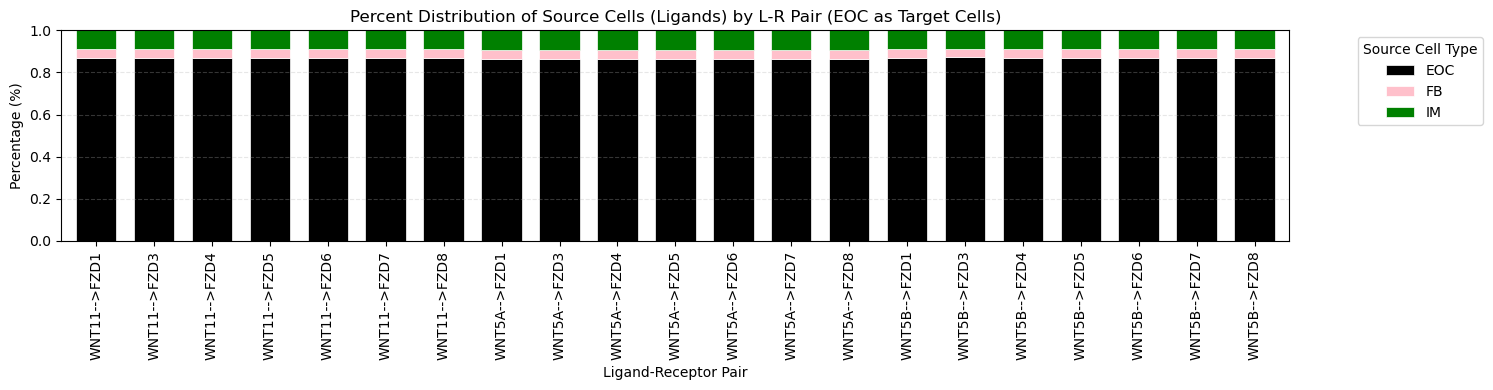

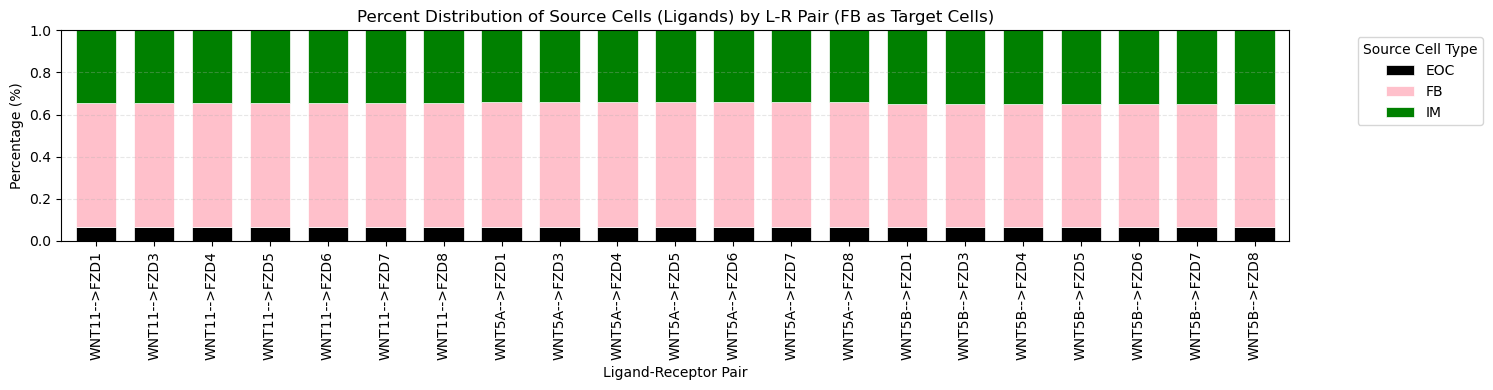

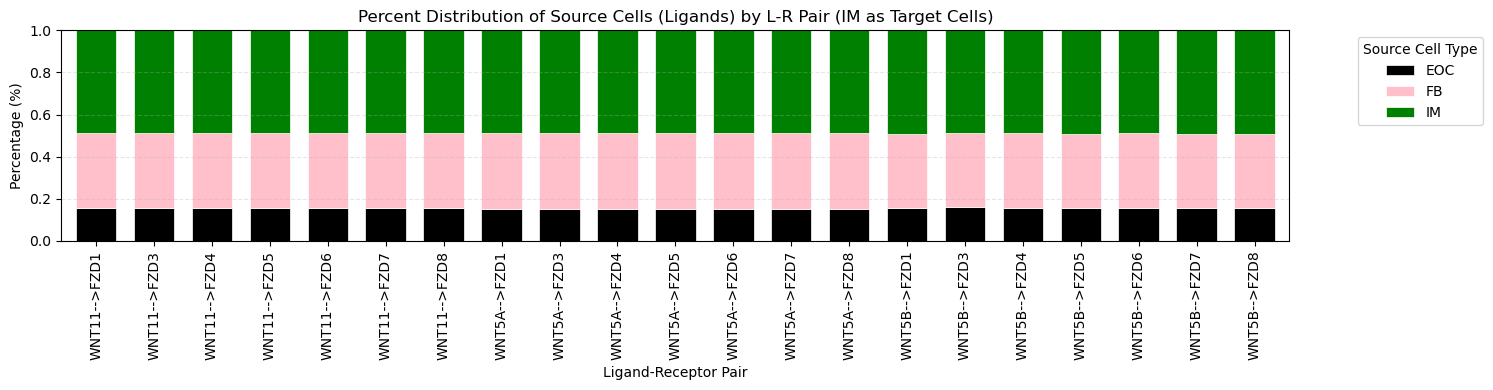

{'EOC': (<Figure size 1500x400 with 1 Axes>,
  <Axes: title={'center': 'Percent Distribution of Source Cells (Ligands) by L-R Pair (EOC as Target Cells)'}, xlabel='Ligand-Receptor Pair', ylabel='Percentage (%)'>),
 'FB': (<Figure size 1500x400 with 1 Axes>,
  <Axes: title={'center': 'Percent Distribution of Source Cells (Ligands) by L-R Pair (FB as Target Cells)'}, xlabel='Ligand-Receptor Pair', ylabel='Percentage (%)'>),
 'IM': (<Figure size 1500x400 with 1 Axes>,
  <Axes: title={'center': 'Percent Distribution of Source Cells (Ligands) by L-R Pair (IM as Target Cells)'}, xlabel='Ligand-Receptor Pair', ylabel='Percentage (%)'>)}

In [125]:
def create_stacked_bar_chart(df_summary, target_cell_type, save_dir=None, figsize=(15, 4), 
                            color_map='viridis', color_dict=None):
    """
    Create a stacked bar chart for the specified target cell type.
    
    Parameters:
    -----------
    df_summary : pandas DataFrame
        Processed summary dataframe with source, target, and percentage calculations
    target_cell_type : str
        The target cell type to filter for (e.g., 'EOC', 'IM', 'FB')
    save_dir : str, optional
        Directory to save the figure. If None, figure is not saved.
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (30, 6).
    color_map : str, optional
        Colormap to use for the stacked bars. Default is 'viridis'.
        Only used if color_dict is None.
    color_dict : dict, optional
        Dictionary mapping source cell types to colors (e.g., {'EOC': 'black', 'FB': 'pink'}).
        If provided, this overrides the color_map parameter.
        
    Returns:
    --------
    tuple
        (fig, ax) matplotlib figure and axis objects for further customization if needed
    """
    # Filter for the target cell type
    df_filtered = df_summary[df_summary['target'] == target_cell_type]
    
    # Create pivot table for stacked bar chart
    pivot_df = df_filtered[['L_R', 'source', 'percentage_L_R_target']].pivot(
        index='L_R', 
        columns='source', 
        values='percentage_L_R_target'
    ).fillna(0)
    
    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=figsize)
    
    # If a color dictionary is provided, create a custom color list
    if color_dict is not None:
        # Get all source cell types in the pivot table
        source_types = pivot_df.columns.tolist()
        
        # Create color list in the same order as the columns
        colors = [color_dict.get(source, 'gray') for source in source_types]
        
        # Plot with custom colors
        pivot_df.plot(
            kind='bar', 
            stacked=True, 
            ax=ax,
            color=colors,  # Use custom colors
            width=0.7, 
            edgecolor='white', 
            linewidth=0.5
        )
    else:
        # Use standard colormap
        pivot_df.plot(
            kind='bar', 
            stacked=True, 
            ax=ax,
            colormap=color_map, 
            width=0.7, 
            edgecolor='white', 
            linewidth=0.5
        )
    
    # Customize the plot
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('Ligand-Receptor Pair')
    ax.set_title(f'Percent Distribution of Source Cells (Ligands) by L-R Pair ({target_cell_type} as Target Cells)')
    ax.legend(title='Source Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Ensure y-axis goes from 0 to 100%
    ax.set_ylim(0, 1)
    
    # Add gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if save_dir is provided
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f'{save_dir}percent_stacked_bar_target_{target_cell_type}.png', 
                   dpi=300, bbox_inches='tight')
    
    return fig, ax

def create_all_target_stacked_charts(df_summary, target_cell_types=None, save_dir=None, figsize=(15, 4), 
                                    color_map='viridis', color_dict=None):
    """
    Create stacked bar charts for all specified target cell types.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataframe with group and weighted_score columns
    target_cell_types : list, optional
        List of target cell types to create charts for. If None, unique target cell types are extracted.
    save_dir : str, optional
        Directory to save the figures. If None, figures are not saved.
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (30, 6).
    color_map : str, optional
        Colormap to use for the stacked bars. Default is 'viridis'.
        Only used if color_dict is None.
    color_dict : dict, optional
        Dictionary mapping source cell types to colors (e.g., {'EOC': 'black', 'FB': 'pink'}).
        If provided, this overrides the color_map parameter.
        
    Returns:
    --------
    dict
        Dictionary mapping target cell types to (fig, ax) tuples
    """
    
    
    # If target_cell_types not provided, extract unique target cell types
    if target_cell_types is None:
        target_cell_types = df_summary['target'].unique()
    
    # Create a stacked bar chart for each target cell type
    figures = {}
    for target in target_cell_types:
        fig, ax = create_stacked_bar_chart(
            df_summary, 
            target, 
            save_dir=save_dir,
            figsize=figsize,
            color_map=color_map,
            color_dict=color_dict
        )
        figures[target] = (fig, ax)
        
        # Display the figure
        plt.show()
    
    return figures

# Example usage with custom color dictionary:
# Define colors for each source cell type
cell_colors = {
    'EOC': 'black',
    'FB': 'pink',
    'IM': 'green',
    'SMC': 'purple',
    'CD4T': 'blue',
    'CD8T': 'lightblue',
    'NK': 'red',
    'Mast': 'orange',
    'B': 'yellow',
    'DC': 'brown',
    'Mono': 'gray',
    'Neut': 'lime'
}


# Example 1: Create a chart with custom colors for one target cell type
# create_stacked_bar_chart(df_summary, 'EOC', save_dir=analysis_save, color_dict=cell_colors)

# Example 2: Create charts for all target cell types with custom colors
create_all_target_stacked_charts(df_summary, save_dir=analysis_save, color_dict=cell_colors)

# Example 3: Create charts for specific target cell types with custom colors
# create_all_target_stacked_charts(df_summary, target_cell_types=['EOC', 'IM'], save_dir=analysis_save, color_dict=cell_colors)

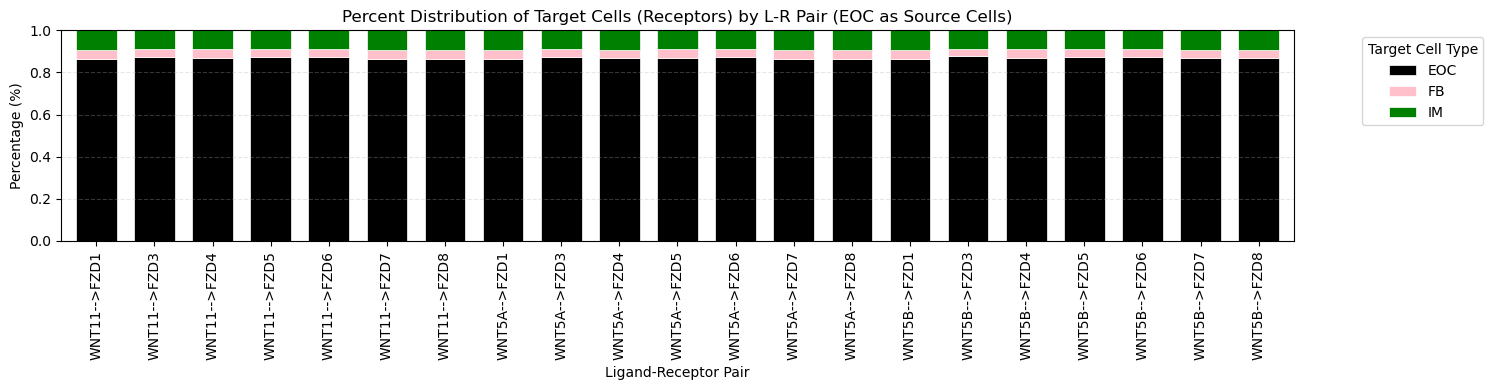

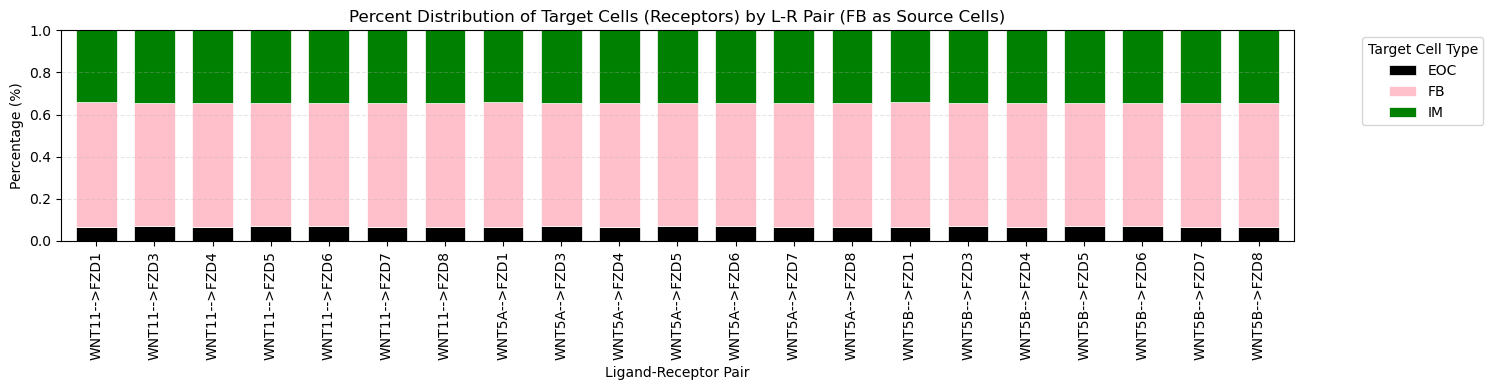

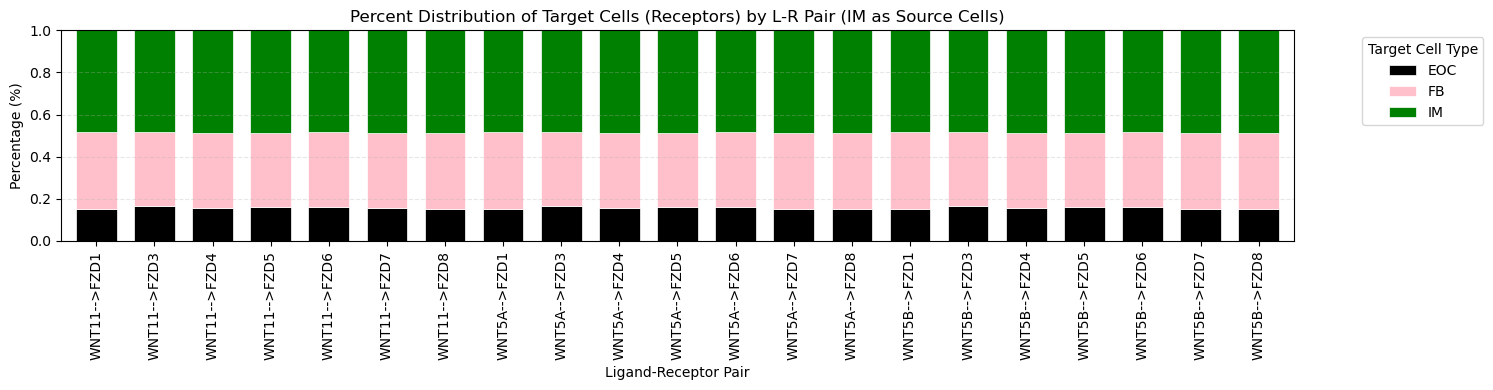

{'EOC': (<Figure size 1500x400 with 1 Axes>,
  <Axes: title={'center': 'Percent Distribution of Target Cells (Receptors) by L-R Pair (EOC as Source Cells)'}, xlabel='Ligand-Receptor Pair', ylabel='Percentage (%)'>),
 'FB': (<Figure size 1500x400 with 1 Axes>,
  <Axes: title={'center': 'Percent Distribution of Target Cells (Receptors) by L-R Pair (FB as Source Cells)'}, xlabel='Ligand-Receptor Pair', ylabel='Percentage (%)'>),
 'IM': (<Figure size 1500x400 with 1 Axes>,
  <Axes: title={'center': 'Percent Distribution of Target Cells (Receptors) by L-R Pair (IM as Source Cells)'}, xlabel='Ligand-Receptor Pair', ylabel='Percentage (%)'>)}

In [127]:
def create_stacked_bar_chart(df_summary, source_cell_type, save_dir=None, figsize=(15, 4), 
                            color_map='viridis', color_dict=None):
    """
    Create a stacked bar chart for the specified target cell type.
    
    Parameters:
    -----------
    df_summary : pandas DataFrame
        Processed summary dataframe with source, target, and percentage calculations
    target_cell_type : str
        The target cell type to filter for (e.g., 'EOC', 'IM', 'FB')
    save_dir : str, optional
        Directory to save the figure. If None, figure is not saved.
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (30, 6).
    color_map : str, optional
        Colormap to use for the stacked bars. Default is 'viridis'.
        Only used if color_dict is None.
    color_dict : dict, optional
        Dictionary mapping target cell types to colors (e.g., {'EOC': 'black', 'FB': 'pink'}).
        If provided, this overrides the color_map parameter.
        
    Returns:
    --------
    tuple
        (fig, ax) matplotlib figure and axis objects for further customization if needed
    """
    # Filter for the source cell type
    df_filtered = df_summary[df_summary['source'] == source_cell_type]
    
    # Create pivot table for stacked bar chart
    pivot_df = df_filtered[['L_R', 'target', 'percentage_L_R_source']].pivot(
        index='L_R', 
        columns='target', 
        values='percentage_L_R_source'
    ).fillna(0)
    
    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=figsize)
    
    # If a color dictionary is provided, create a custom color list
    if color_dict is not None:
        # Get all source cell types in the pivot table
        source_types = pivot_df.columns.tolist()
        
        # Create color list in the same order as the columns
        colors = [color_dict.get(source, 'gray') for source in source_types]
        
        # Plot with custom colors
        pivot_df.plot(
            kind='bar', 
            stacked=True, 
            ax=ax,
            color=colors,  # Use custom colors
            width=0.7, 
            edgecolor='white', 
            linewidth=0.5
        )
    else:
        # Use standard colormap
        pivot_df.plot(
            kind='bar', 
            stacked=True, 
            ax=ax,
            colormap=color_map, 
            width=0.7, 
            edgecolor='white', 
            linewidth=0.5
        )
    
    # Customize the plot
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('Ligand-Receptor Pair')
    ax.set_title(f'Percent Distribution of Target Cells (Receptors) by L-R Pair ({source_cell_type} as Source Cells)')
    ax.legend(title='Target Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Ensure y-axis goes from 0 to 100%
    ax.set_ylim(0, 1)
    
    # Add gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if save_dir is provided
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f'{save_dir}percent_stacked_bar_source_{source_cell_type}.png', 
                   dpi=300, bbox_inches='tight')
    
    return fig, ax

def create_all_target_stacked_charts(df_summary, source_cell_types=None, save_dir=None, figsize=(15, 4), 
                                    color_map='viridis', color_dict=None):
    """
    Create stacked bar charts for all specified source cell types.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataframe with group and weighted_score columns
    target_cell_types : list, optional
        List of source cell types to create charts for. If None, unique source cell types are extracted.
    save_dir : str, optional
        Directory to save the figures. If None, figures are not saved.
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (30, 6).
    color_map : str, optional
        Colormap to use for the stacked bars. Default is 'viridis'.
        Only used if color_dict is None.
    color_dict : dict, optional
        Dictionary mapping target cell types to colors (e.g., {'EOC': 'black', 'FB': 'pink'}).
        If provided, this overrides the color_map parameter.
        
    Returns:
    --------
    dict
        Dictionary mapping source cell types to (fig, ax) tuples
    """
    
    
    # If target_cell_types not provided, extract unique target cell types
    if source_cell_types is None:
        source_cell_types = df_summary['source'].unique()
    
    # Create a stacked bar chart for each target cell type
    figures = {}
    for target in source_cell_types:
        fig, ax = create_stacked_bar_chart(
            df_summary, 
            target, 
            save_dir=save_dir,
            figsize=figsize,
            color_map=color_map,
            color_dict=color_dict
        )
        figures[target] = (fig, ax)
        
        # Display the figure
        plt.show()
    
    return figures

# Example usage with custom color dictionary:
# Define colors for each source cell type
cell_colors = {
    'EOC': 'black',
    'FB': 'pink',
    'IM': 'green',
    'SMC': 'purple',
    'CD4T': 'blue',
    'CD8T': 'lightblue',
    'NK': 'red',
    'Mast': 'orange',
    'B': 'yellow',
    'DC': 'brown',
    'Mono': 'gray',
    'Neut': 'lime'
}

# Example 1: Create a chart with custom colors for one target cell type
# create_stacked_bar_chart(df_summary, 'EOC', save_dir=analysis_save, color_dict=cell_colors)

# Example 2: Create charts for all target cell types with custom colors
create_all_target_stacked_charts(df_summary, save_dir=analysis_save, color_dict=cell_colors)

# Example 3: Create charts for specific target cell types with custom colors
# create_all_target_stacked_charts(df, target_cell_types=['EOC', 'IM'], save_dir=analysis_save, color_dict=cell_colors)

Starting visualization...
Visualizing pathway: WNT5A_FZD8, ligand: WNT5A
Source cells: ['FB'], Target cells: ['IM', 'EOC']
Filtering data...
Found 514564 matching interactions.
Aggregating data...
Target cells GDF size: 1306
Source cells GDF size: 394
Setting up color mappings...
Creating plot...
Creating target cell patches...
Creating source cell patches...
Adding colorbars and legend...
Visualization complete. Total time: 12.21 seconds


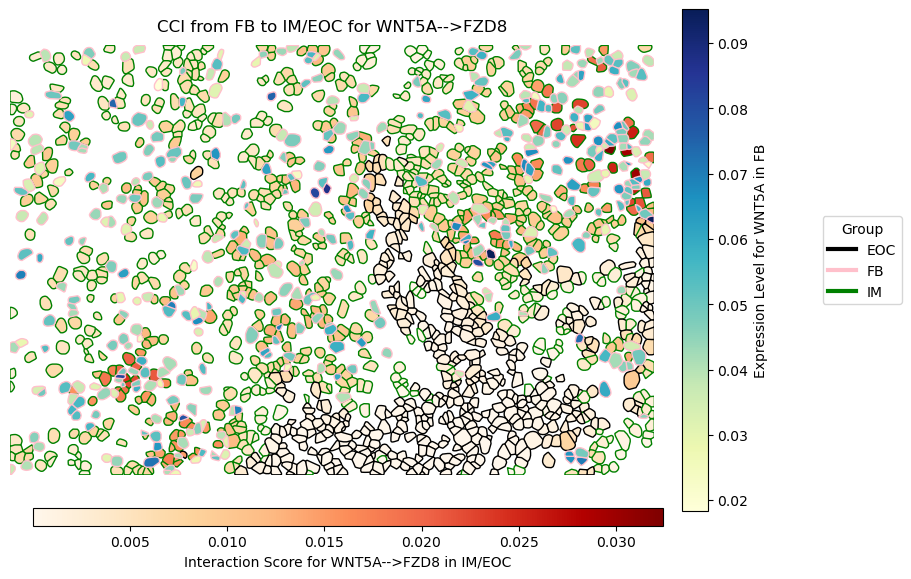

(<Figure size 900x900 with 3 Axes>,
 <Axes: title={'center': 'CCI from FB to IM/EOC for WNT5A-->FZD8'}>)

In [101]:
def plot_CCI(df_weighted, gdf, counts_sub, pathway, ligand, source_cell, target_cell, 
           edge_color_map, analysis_save, xlim_image, ylim_image):
    """
    Create a Cell-Cell Interaction (CCI) visualization plot.
    
    Parameters:
    -----------
    df_weighted : pandas DataFrame
        DataFrame containing weighted interaction scores.
    gdf : GeoDataFrame
        GeoDataFrame containing cell geometries.
    counts_sub : pandas DataFrame
        DataFrame containing expression counts.
    pathway : str
        The pathway to visualize (e.g., 'WNT5A_FZD8').
    ligand : str
        The ligand to visualize (e.g., 'WNT5A').
    source_cell : list
        List of source cell types (e.g., ['FB']).
    target_cell : list
        List of target cell types (e.g., ['EOC', 'IM']).
    edge_color_map : dict
        Dictionary mapping cell types to colors.
    analysis_save : str
        Directory path where to save the figure.
    xlim_image : float
        X-axis limit for the plot.
    ylim_image : float
        Y-axis limit for the plot.
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import matplotlib.cm as cm
    from matplotlib.lines import Line2D
    from matplotlib.colors import to_hex
    import numpy as np
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Polygon
    import time
    
    # Start timer
    start_time = time.time()
    print("Starting visualization...")
    print(f"Visualizing pathway: {pathway}, ligand: {ligand}")
    print(f"Source cells: {source_cell}, Target cells: {target_cell}")

    # Limit columns in merges to only those needed
    needed_columns_gdf = ['cell', 'big_cell_type', 'geometry']
    needed_columns_counts = ['cell', ligand]

    # Filter data with more efficient query
    print("Filtering data...")
    df_tmp = df_weighted[(df_weighted['target_cell_label'].isin(target_cell)) &
                        (df_weighted['source_cell_label'].isin(source_cell)) &
                        (df_weighted['L_R'].isin([pathway]))]

    # Check if filtering returned any results
    if len(df_tmp) == 0:
        print("No data found for the specified pathway and cell types.")
        # Plot empty visualization with a message
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.text(0.5, 0.5, f"No interactions found for {pathway}\nfrom {source_cell} to {target_cell}", 
                ha='center', va='center', fontsize=14)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        plt.savefig(analysis_save+'CCI_'+pathway+'_'+'_'.join(source_cell)+'_to_'+'_'.join(target_cell)+'_empty.png')
        plt.show()
        return  # Exit the function early
    
    print(f"Found {len(df_tmp)} matching interactions.")
    
    # Simplify aggregation
    print("Aggregating data...")
    df_tmp = df_tmp[['target_cell', 'weighted_score']]
    df_tmp = df_tmp.groupby('target_cell').mean().reset_index()
    
    # More efficient merges with only needed columns
    gdf_subset = gdf[gdf['big_cell_type'].isin(target_cell)][needed_columns_gdf].copy()
    print(f"Target cells GDF size: {len(gdf_subset)}")
    
    df_tmp = df_tmp.merge(gdf_subset, left_on='target_cell', right_on='cell', how='right')
    df_tmp['weighted_score'].fillna(0, inplace=True)
    
    # Similarly optimize the source cell data preparation
    gdf_subset_fb = gdf[gdf['big_cell_type'].isin(source_cell)][needed_columns_gdf].copy()
    print(f"Source cells GDF size: {len(gdf_subset_fb)}")
    
    # Only select needed columns from counts_sub
    if counts_sub is not None and ligand in counts_sub.columns:
        counts_sub_minimal = counts_sub[needed_columns_counts].copy()
        df_tmp1 = gdf_subset_fb.merge(counts_sub_minimal, on='cell', how='left')
        df_tmp1[ligand].fillna(0, inplace=True)
    else:
        print("Warning: counts_sub DataFrame not provided or missing ligand column")
        df_tmp1 = gdf_subset_fb.copy()
        df_tmp1[ligand] = 0  # Default value if data not available
    
    # Define normalizations and color mappings
    print("Setting up color mappings...")
    norm = colors.Normalize(vmin=df_tmp['weighted_score'].min(), vmax=df_tmp['weighted_score'].max())
    cmap = cm.OrRd
    
    norm1 = colors.Normalize(vmin=df_tmp1[ligand].min(), vmax=df_tmp1[ligand].max())
    cmap1 = cm.YlGnBu
    
    # Vectorized operations instead of apply/map
    df_tmp['fill_color'] = [to_hex(cmap(norm(x))[:3]) for x in df_tmp['weighted_score']]
    df_tmp['edge_color'] = df_tmp['big_cell_type'].map(edge_color_map)
    
    df_tmp1['fill_color'] = [to_hex(cmap1(norm1(x))[:3]) for x in df_tmp1[ligand]]
    df_tmp1['edge_color'] = df_tmp1['big_cell_type'].map(edge_color_map)
    
    # Use PatchCollection for faster plotting
    print("Creating plot...")
    fig, ax = plt.subplots(figsize=(9, 9))
    
    # Function to convert geometry to matplotlib patches
    def geometry_to_patches(gdf, fill_colors, edge_colors):
        patches = []
        fc = []
        ec = []
        
        for idx, row in gdf.iterrows():
            if row['geometry'] is None:
                continue
                
            if row['geometry'].geom_type == 'Polygon':
                coords = np.array(row['geometry'].exterior.coords)
                patches.append(Polygon(coords))
                fc.append(row['fill_color'])
                ec.append(row['edge_color'])
            elif row['geometry'].geom_type == 'MultiPolygon':
                for geom in row['geometry'].geoms:
                    coords = np.array(geom.exterior.coords)
                    patches.append(Polygon(coords))
                    fc.append(row['fill_color'])
                    ec.append(row['edge_color'])
        
        return patches, fc, ec
    
    # Create patches for target cells
    print("Creating target cell patches...")
    target_patches, target_fc, target_ec = geometry_to_patches(
        df_tmp, df_tmp['fill_color'], df_tmp['edge_color'])
    
    # Create patch collection for target cells
    if target_patches:
        target_collection = PatchCollection(
            target_patches, facecolors=target_fc, edgecolors=target_ec, linewidths=1.0)
        ax.add_collection(target_collection)
    
    # Create patches for source cells
    print("Creating source cell patches...")
    source_patches, source_fc, source_ec = geometry_to_patches(
        df_tmp1, df_tmp1['fill_color'], df_tmp1['edge_color'])
    
    # Create patch collection for source cells
    if source_patches:
        source_collection = PatchCollection(
            source_patches, facecolors=source_fc, edgecolors=source_ec, linewidths=1.0)
        ax.add_collection(source_collection)
    
    # Set axis limits using data bounds
    ax.set_xlim(0, xlim_image)
    ax.set_ylim(0, ylim_image)
    
    # Add colorbars efficiently
    print("Adding colorbars and legend...")
    cax_horizontal = plt.axes([0.15, 0.2, 0.7, 0.02]) 
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax_horizontal, orientation='horizontal')
    cbar.set_label('Interaction Score for '+pathway.replace('_','-->')+' in '+'/'.join(target_cell))
    
    sm1 = cm.ScalarMappable(cmap=cmap1, norm=norm1)
    sm1.set_array([])
    cbar1 = plt.colorbar(sm1, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
    cbar1.set_label('Expression Level for '+ligand+' in '+'/'.join(source_cell))
    
    # Create legend more efficiently
    legend_elements = [Line2D([0], [0], color=color, lw=3, label=group)
                    for group, color in edge_color_map.items()]
    ax.legend(handles=legend_elements, title='Group', loc='center left', bbox_to_anchor=(1.25, 0.5))
    
    # Set final plot properties
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("CCI from "+'/'.join(source_cell)+" to "+'/'.join(target_cell)+" for "+pathway.replace('_','-->'), pad=10)
    
    # Report execution time
    print(f"Visualization complete. Total time: {time.time() - start_time:.2f} seconds")
    
    # Save figure with bbox_inches='tight' to include the legend
    plt.savefig(analysis_save+'CCI_'+pathway+'_'+'_'.join(source_cell)+'_to_'+'_'.join(target_cell)+'.png', 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    return fig, ax  # Return the figure and axes for potential further customization

pathway='WNT5A_FZD8'
ligand='WNT5A'
source_cell=['FB']
target_cell=['IM','EOC']

edge_color_map = {
    'EOC': 'black',
    'FB': 'pink',
    'IM': 'green'
}

plot_CCI(df_weighted, gdf, counts_sub, pathway, ligand, source_cell, target_cell, 
           edge_color_map, analysis_save, xlim_image, ylim_image)

In [98]:
def save_as_parquet(df, filepath, compression='snappy'):
    """
    Save DataFrame as Parquet with specified compression.
    Parquet is highly recommended for big data due to its column-oriented storage.
    
    Args:
        df: DataFrame to save
        filepath: Path where file will be saved
        compression: Compression algorithm ('snappy', 'gzip', 'brotli', None)
    """
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    print(f"Saving DataFrame with shape {df.shape} to {filepath}...")
    df.to_parquet(filepath, compression=compression, index=False)
    print(f"Successfully saved! File size: {os.path.getsize(filepath) / (1024*1024):.2f} MB")
    

save_as_parquet(df_weighted, data_save+'CCI_SS_magic_'+'fov'+str(fov_chosen)+'_'+ligand+'.parquet')


Saving DataFrame with shape (60690000, 21) to ../data/CCI_SS_magic_fov16.parquet...
Successfully saved! File size: 3051.11 MB


16